<a href="https://colab.research.google.com/github/seeedata/Kaggle_Study/blob/main/1120%20Detecting%20Anomaly%20using%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Anomaly using Autoencoder!

https://www.kaggle.com/code/ohseokkim/dectecting-anomaly-using-autoencoder/notebook#Splitting-Dataset

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/6주차'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/6주차/ecg.csv/ecg.csv


# Introduction

**What is anomaly detection?**

> Anomaly detection (aka outlier analysis) is a step in data mining that identifies data points, events, and/or observations that deviate from a dataset’s normal behavior. Anomalous data can indicate critical incidents, such as a technical glitch, or potential opportunities, for instance a change in consumer behavior. Machine learning is progressively being used to automate anomaly detection.

**Autoencoder-based anomaly detection**

> **Autoencoder-based anomaly detection** is to perform anomaly detection by compressing normal data into a latent space of a smaller dimension than the original data through the autoencoder, then restoring it and comparing the difference between the restored data and the original data. The part that encodes the normal data to the lower dimension is called the encoder, and the part that decodes the compressed sample back to the original dimension is called the decoder. The data expression in the latent space where the data is compressed by the encoder is called a latent variable. The autoencoder learns through the process of minimizing the difference between the original data and the restored data, and in the process, the features of the learning data are naturally extracted to construct a latent space.

> The specific way an autoencoder compares the input and output differences also determines the performance and characteristics of anomaly detection. The most basic method considers the original data and the restored data as points in the n-dimensional coordinate space, and uses the distance between the two points as an index of the input/output difference. This metric is called the reconstruction error. Since the autoencoder used for anomaly detection is trained to restore normal data well, compression and restoration cannot be performed effectively when abnormal data is input. Therefore, the abnormal data has a large restoration error.

> The restoration error can be used as one of the anomaly scores that indicate the degree of anomaly of a given data. If the anomaly score is greater than a predetermined threshold, the data is considered anomaly, and if it is small, it is considered normal. Thresholds are set differently depending on the specific characteristics and requirements of the anomaly detection you want to perform.

**What is Autoencoder?**

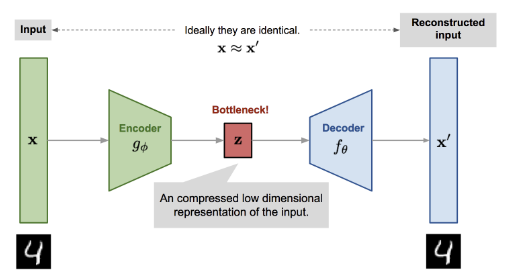

The auto encoder learns to produce the same output as the input as much as possible. Through this learning process, the representation of the input can be effectively compressed in the latent space. In other words, it compresses the dimensions and stores the representation of the input in the latent space.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from plotly.subplots import make_subplots
import plotly.graph_objects as go
pip install umap-learn
from umap import UMAP
import umap.plot
!pip install holoviews
import holoviews as hv
from holoviews import opts
!pip install bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6
!pip install datashader
import datashader as ds, pandas as pd, colorcet

This dataset contains the ECG readings of patients. Each row corresponds to a single complete ECG of a patient. Every single ECG is composed of 140 data points(readings).

1. Columns 0-139 contain the ECG data point for a particular patient. These are floating point numbers.
2. The label which shows whether the ECG is normal or abnormal. It is a categorical variable with value either 0 or 1.

# Utility Functions

In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('confusion matrix')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

# Doing Simple EDA

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/6주차/ecg.csv/ecg.csv', header=None)
dataframe

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [ ]:
#Numpy 배열 형태로 raw_data에 저장
raw_data = dataframe.values
raw_data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [ ]:
#dataframe의 상위 5개 행을 가져와서 스타일을 지정한 뒤에 출력
dataframe.head().style.set_properties(**{'background-color': 'black',  #배경색
                                         'color': 'white',  #글자색
                                         'border-color': 'white'})  #테이블의 테두리색

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,0.071195,0.123925,0.103124,0.225228,0.128683,0.302483,0.257276,0.196352,0.179383,0.244729,0.341217,0.328204,0.406042,0.446605,0.424068,0.481512,0.477844,0.624083,0.574585,0.598013,0.564592,0.607979,0.620635,0.656253,0.684748,0.694273,0.665584,0.575796,0.638135,0.614917,0.569083,0.468576,0.442818,0.468274,0.432493,0.407958,0.418623,0.362531,0.410959,0.471666,0.372167,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.000000
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,0.271695,0.259003,0.269202,0.127065,0.202073,0.255983,0.153115,0.210216,0.191082,0.190927,0.210510,0.207108,0.204888,0.200865,0.346920,0.348002,0.254537,0.331975,0.356690,0.349930,0.430380,0.467502,0.486063,0.403188,0.478956,0.397392,0.464120,0.451795,0.361361,0.379831,0.342785,0.399107,0.387508,0.255703,0.284034,0.284993,0.250108,0.173036,0.149423,0.141685,0.222261,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.000000
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,0.109521,0.158078,0.291898,0.261294,0.188407,0.140651,0.263365,0.287207,0.314317,0.177942,0.138290,0.321069,0.458168,0.251916,0.261353,0.277488,0.298793,0.459075,0.419147,0.520509,0.537761,0.603211,0.475634,0.521693,0.735248,0.729541,0.718523,0.498433,0.545441,0.604827,0.521296,0.394381,0.405020,0.597563,0.531130,0.377651,0.467701,0.457569,0.341116,0.407913,0.459127,0.403937,0.298191,0.46110

# Checking Target Imbalance

In [ ]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal', 'Abnormal']
values = dataframe[140].value_counts() / dataframe[140].shape[0]  #y 비율

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent',  #마우스를 차트 위에 올렸을 때 라벨과 백분율을 보여줌
                  textinfo='percent',  #각 부분에 백분율을 표시
                  textfont_size=20,  #텍스트의 크기
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))  #colors: 부분별 색상
                                                                                    #line: 테두리의 색상과 너비
fig.update_layout(
    title_text="ECG dataset",
    title_font_color="white",
    paper_bgcolor="black",  #그래프의 배경색
    plot_bgcolor='black',  #플롯 영역의 배경색
    font_color="white",  #전체적인 글자색
)
fig.show()

Target distribution is balanced.

# Splitting Dataset

In [ ]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

# Preprocessing

In [ ]:
tf.reduce_min(train_data)

<tf.Tensor: shape=(), dtype=float64, numpy=-6.2808752>

In [ ]:
tf.reduce_max(train_data)

<tf.Tensor: shape=(), dtype=float64, numpy=7.4021031>

In [ ]:
#train_data에서 최소값 계산
#tf.reduce_min: 데이터의 모든 원소를 최소값인 하나의 값으로 축소
min_val = tf.reduce_min(train_data)
#train_data에서 최대값 계산
max_val = tf.reduce_max(train_data)

#train_data 정규화
train_data = (train_data - min_val) / (max_val - min_val)
#test data 정규화
test_data = (test_data - min_val) / (max_val - min_val)

## 정규화된 데이터를 tf.float32 데이터 타입으로 변환
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Train the autoencoder using only the normal rhythm labeled 1 on this dataset. Separates normal and abnormal rhythms.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :", len(train_labels))
print("the length of test :", len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

the length of train : 3998
the length of test : 1000


Plot the normal ECG.

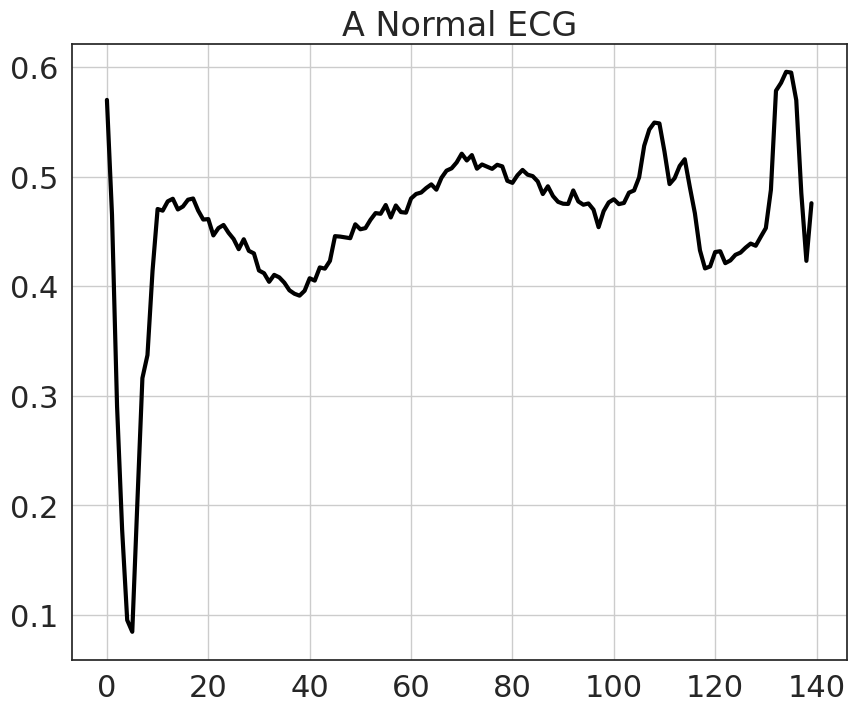

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)  #글꼴 크기를 2배로
sns.set_style("white")  #배경을 흰색으로
plt.grid()  #그래프에 격자 추가
plt.plot(np.arange(140), normal_train_data[0], color='black', linewidth=3.0)
plt.title("A Normal ECG");

Plot the abnormal ECG.

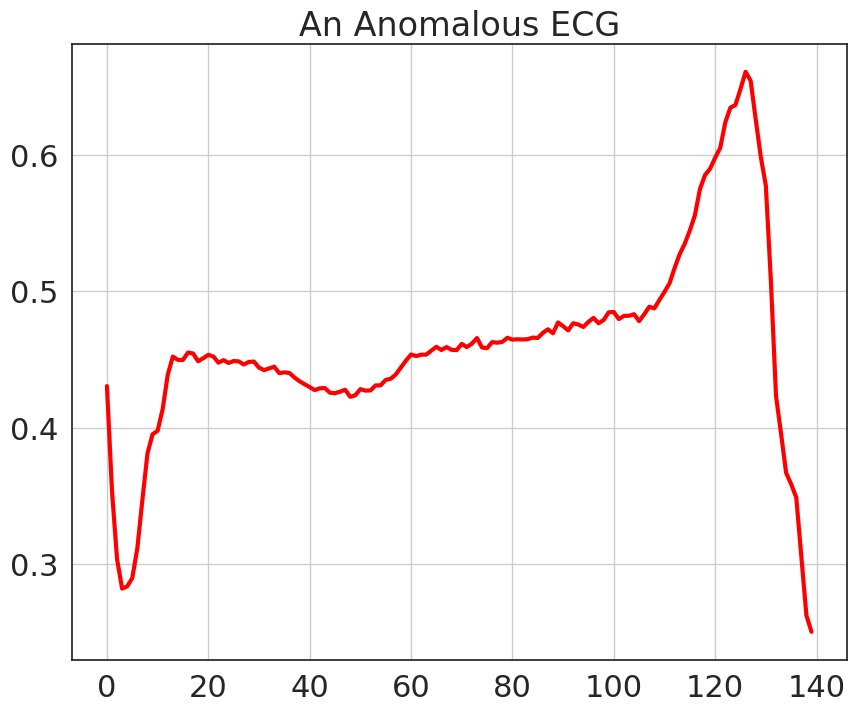

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0], color='red', linewidth=3.0)
plt.title("An Anomalous ECG");

# Modeling

In [ ]:
#TensorFlow의 Model 클래스를 기반으로 커스텀 모델인 AnomalyDetector를 정의
class AnomalyDetector(Model):


    def __init__(self):

        #상위 클래스인 Model 클래스의 생성자 호출
        super(AnomalyDetector, self).__init__()

        ## Encoder
        self.encoder = tf.keras.Sequential([
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu")])

        ## Decoder
        self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(140, activation="sigmoid")])  #출력층


    ##forward pass 정의
    def call(self, x):
        #입력 x를 인코더에 전달하여 인코딩된 특성을 추출
        encoded = self.encoder(x)
        #인코딩된 특성을 디코더에 전달하여 디코딩된 출력을 생성
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

# Training

The autoencoder is trained using only regular ECGs, but evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 5s 244ms/step - loss: 0.0586 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0567 - val_loss: 0.0525
Epoch 3/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0551 - val_loss: 0.0511
Epoch 4/20
5/5 [==============================] - 0s 38ms/step - loss: 0.0527 - val_loss: 0.0497
Epoch 5/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0496 - val_loss: 0.0484
Epoch 6/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 7/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0420 - val_loss: 0.0443
Epoch 8/20
5/5 [==============================] - 0s 52ms/step - loss: 0.0381 - val_loss: 0.0421
Epoch 9/20
5/5 [==============================] - 0s 47ms/step - loss: 0.0345 - val_loss: 0.0408
Epoch 10/20
5/5 [==============================] - 0s 34ms/step - loss: 0.0314 - val_loss: 0.0393
Epoch 11/20
5/5 [===========

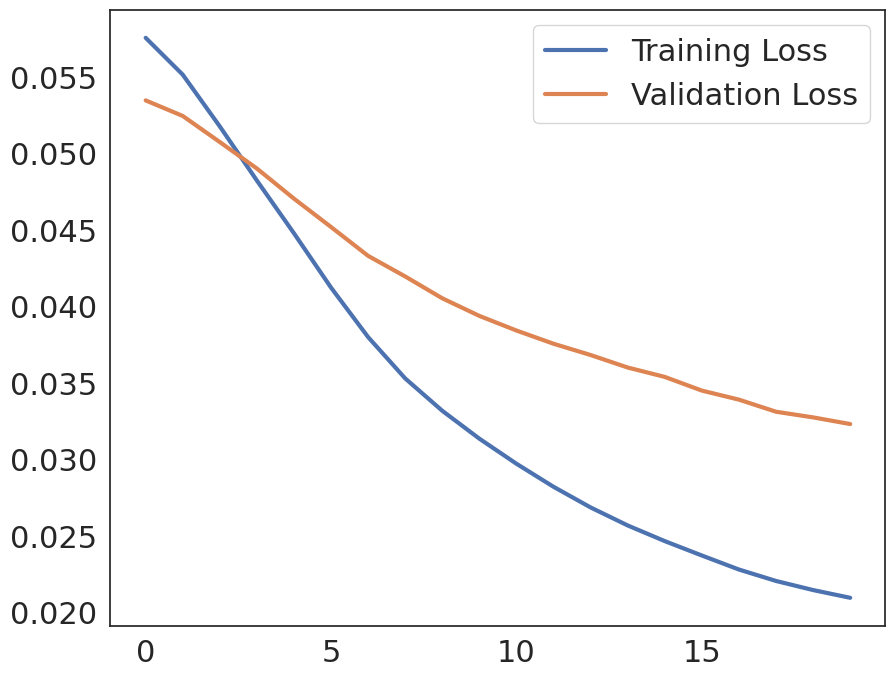

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss", linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=3.0)
plt.legend();

If the reconstruction error is greater than one standard deviation from the normal training example, classify the ECG as abnormal. First, let's plot the normal ECG of the training set, the reconstruction after being encoded and decoded by the autoencoder, and the reconstruction error.

# Testing using normal data

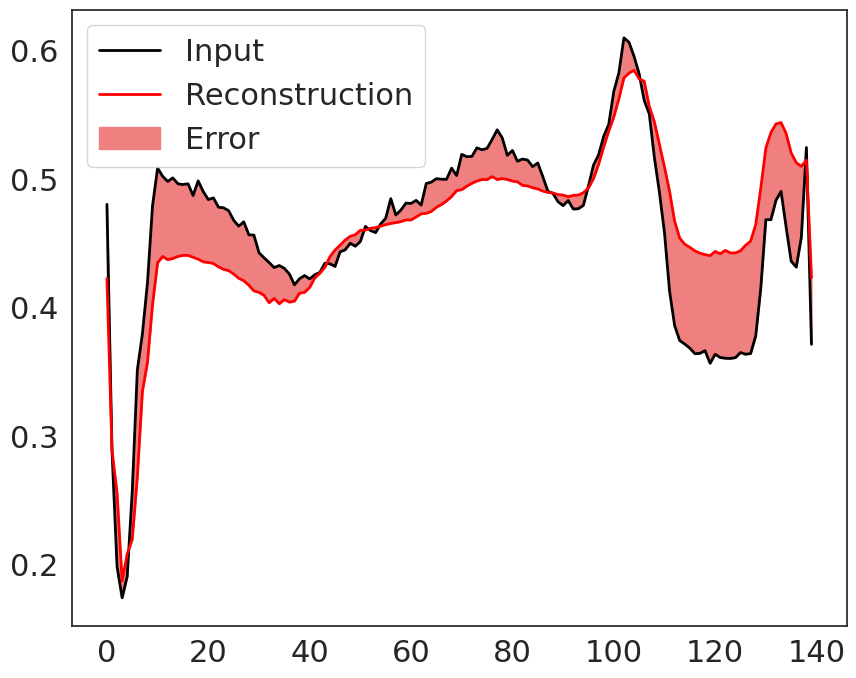

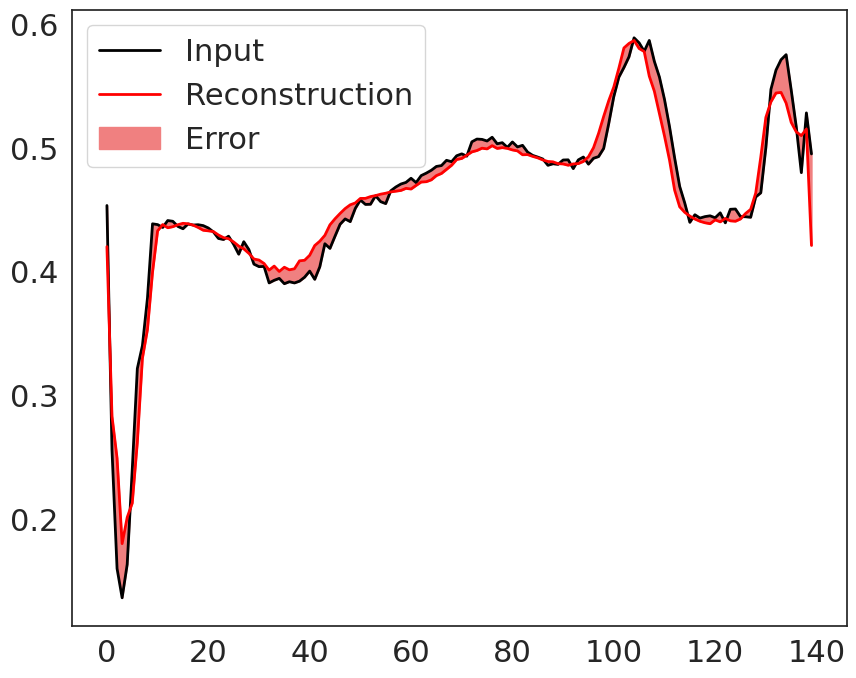

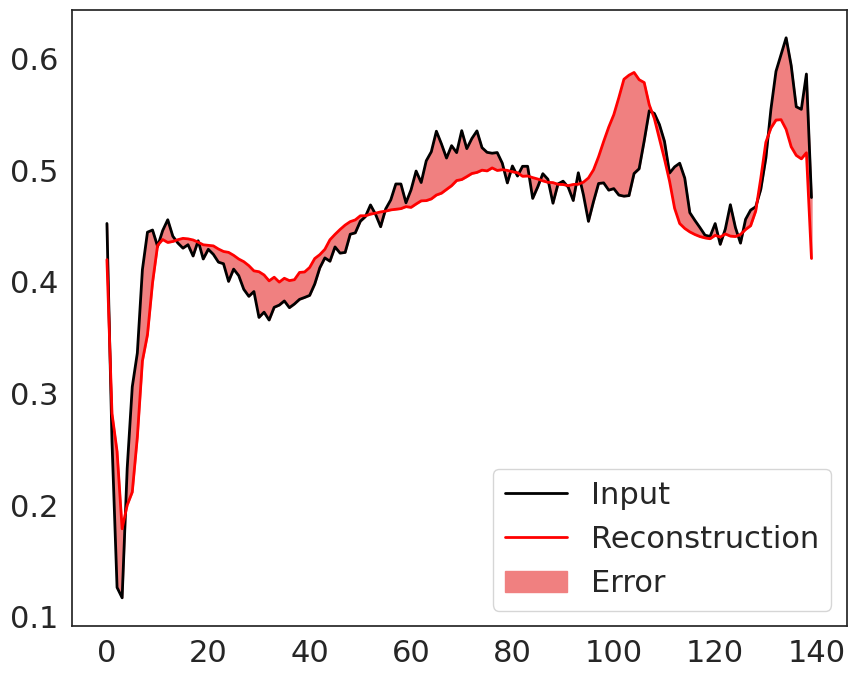

In [ ]:
#인코딩된 데이터를 넘파이 배열로 변환
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
#디코딩된 데이터를 넘파이 배열로 변환
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0, 3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'black', linewidth=2)
    plt.plot(decoded_imgs[i], 'red', linewidth=2)
    #normal_test_data와 decoded_imgs 사이의 오차 시각화
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [ ]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1
encoded_imgs_normal

,0,1,2,3,4,5,6,7,label
0,0.0,0.0,0.0,0.0,0.0,0.0,2.156333,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,2.234380,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,2.250396,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,2.099257,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,2.192823,0.0,1
...,...,...,...,...,...,...,...,...,...
555,0.0,0.0,0.0,0.0,0.0,0.0,2.200716,0.0,1
556,0.0,0.0,0.0,0.0,0.0,0.0,2.214293,0.0,1
557,0.0,0.0,0.0,0.0,0.0,0.0,2.156887,0.0,1
558,0.0,0.0,0.0,0.0,0.0,0.0,2.197623,0.0,1


# Testing using abnormal data

Create a similar plot, this time from abnormal testing examples.

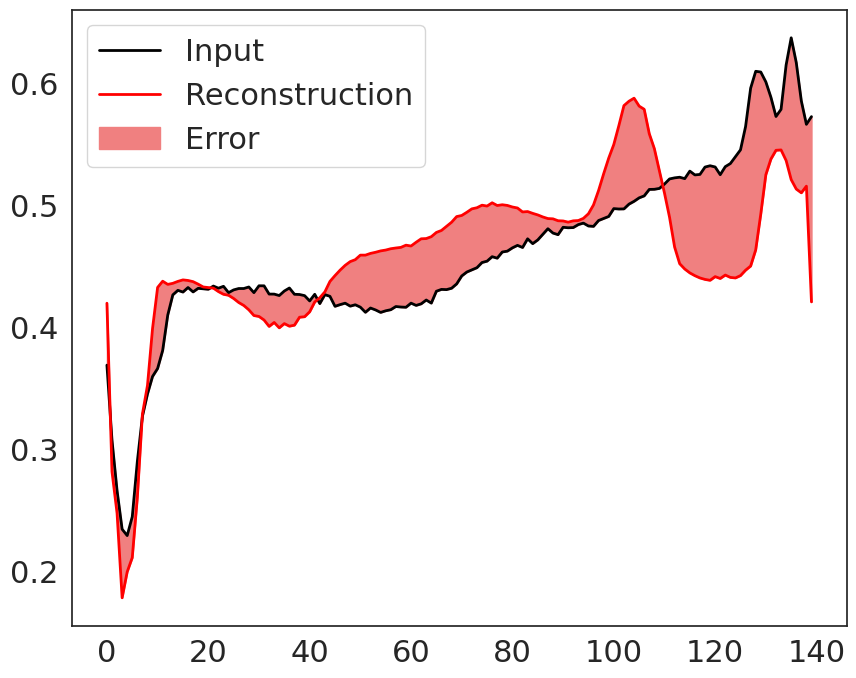

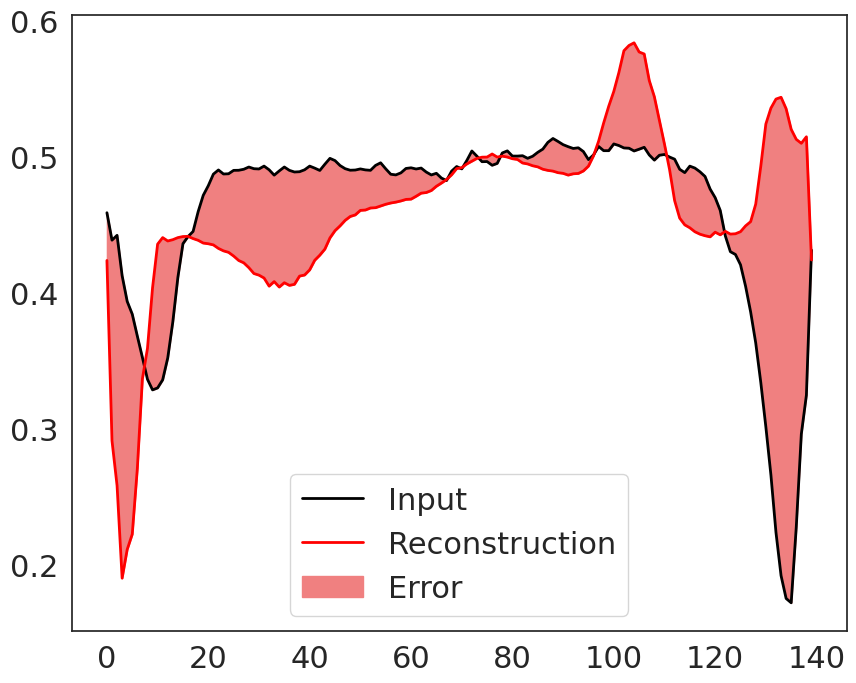

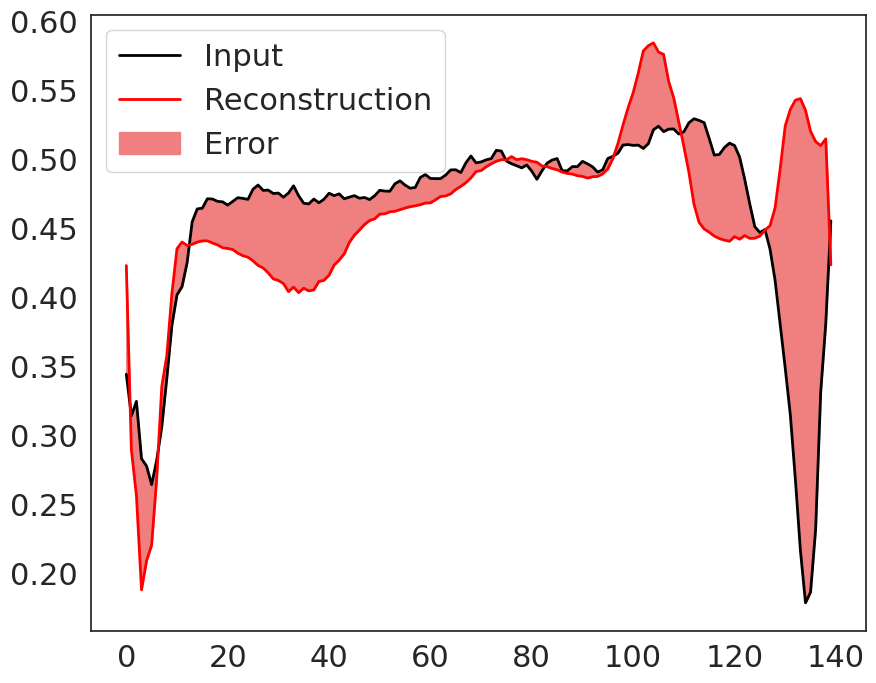

In [ ]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0, 3):
    plt.figure(figsize=(10,8))
    sns.set(font_scale = 2)
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'black', linewidth=2)
    plt.plot(decoded_imgs[i], 'red', linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [ ]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0
encoded_imgs_abnormal

,0,1,2,3,4,5,6,7,label
0,0.0,0.0,0.0,0.0,0.0,0.0,2.257324,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.122038,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,2.145202,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,2.227934,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.192632,0.0,0
...,...,...,...,...,...,...,...,...,...
435,0.0,0.0,0.0,0.0,0.0,0.0,2.123302,0.0,0
436,0.0,0.0,0.0,0.0,0.0,0.0,2.162322,0.0,0
437,0.0,0.0,0.0,0.0,0.0,0.0,2.122948,0.0,0
438,0.0,0.0,0.0,0.0,0.0,0.0,2.145073,0.0,0


# Ploting the Latent Space after Dimension Reduction

In [ ]:
all_encoded = pd.concat([encoded_imgs_normal, encoded_imgs_abnormal])

<Axes: >

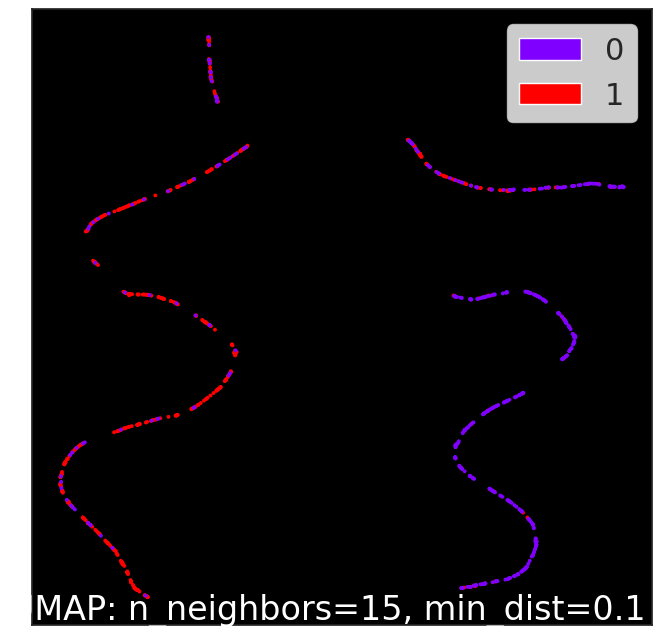

In [ ]:
## UMAP(Uniform Manifold Approximation and Projection)을 사용하여 데이터를 저차원으로 투영한 다음, 이를 시각화

#UMAP 모델 학습
mapper = umap.UMAP().fit(all_encoded.iloc[:, :8])
#데이터 시각화
#각 점은 데이터의 투영을 나타냄
#labels로 8열의 레이블을 기준으로 각 점의 색상 지정
#theme을 fire 시각화 테마 선택
umap.plot.points(mapper, labels=all_encoded.iloc[:, 8], theme='fire')

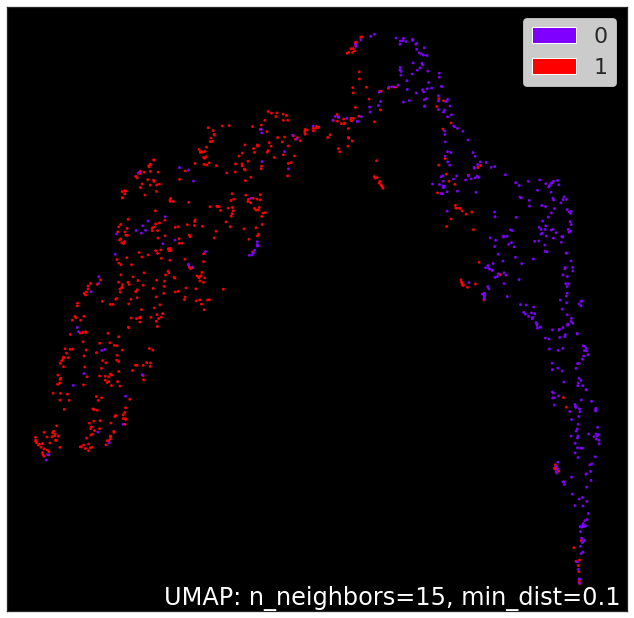

The figure above shows Dimension Reduction of the latent space for normal and abnormal data. This latent space is a space that has undergone Dimension Reduction by compressing 140-dimensional input into 8-dimensional space. We compressed this space back into two dimensions to obtain the picture above.

Looking at the above figure again, it can be confirmed that normal and abnormal data are well separated in the latent space. This is the power of autoencoders, and it can be seen as one of the ways to solve the dimensional curse from the neural network point of view.

# UMAP connectivity plot

UMAP works by constructing an intermediate topological representation of the approximate manifold the data may have been sampled from. In practice this structure can be simplified down to a weighted graph. Sometimes it can be beneficial to see how that graph (representing connectivity in the manifold) looks with respect to the resulting embedding. It can be used to better understand the embedding, and for diagnostic purposes.

<Axes: >

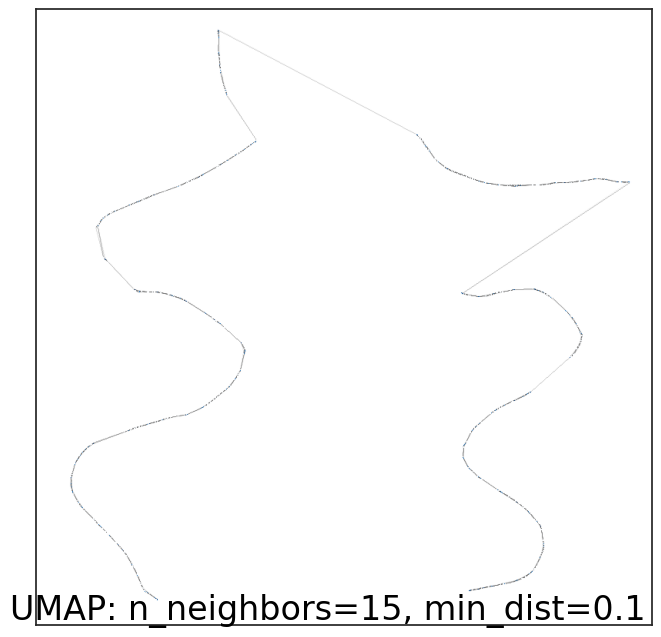

In [ ]:
umap.plot.connectivity(mapper, show_points=True)

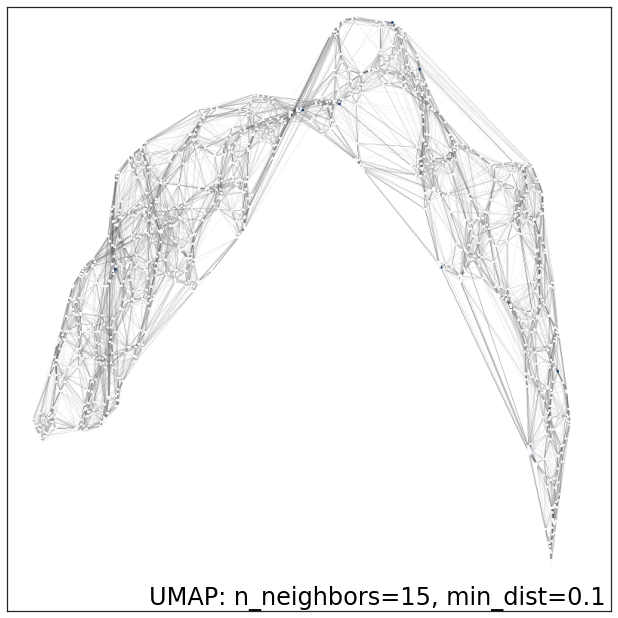

# Detecting Anomaly

Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, we compute the mean error for normal examples in the training set, and then classify future examples as abnormal if the reconstruction error is greater than the standard deviation of the training set.

Plot the reconstruction error for normal ECGs in the training set.

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

74/74 [==============================] - 1s 6ms/step


In [ ]:
np.mean(train_loss)

0.020724017

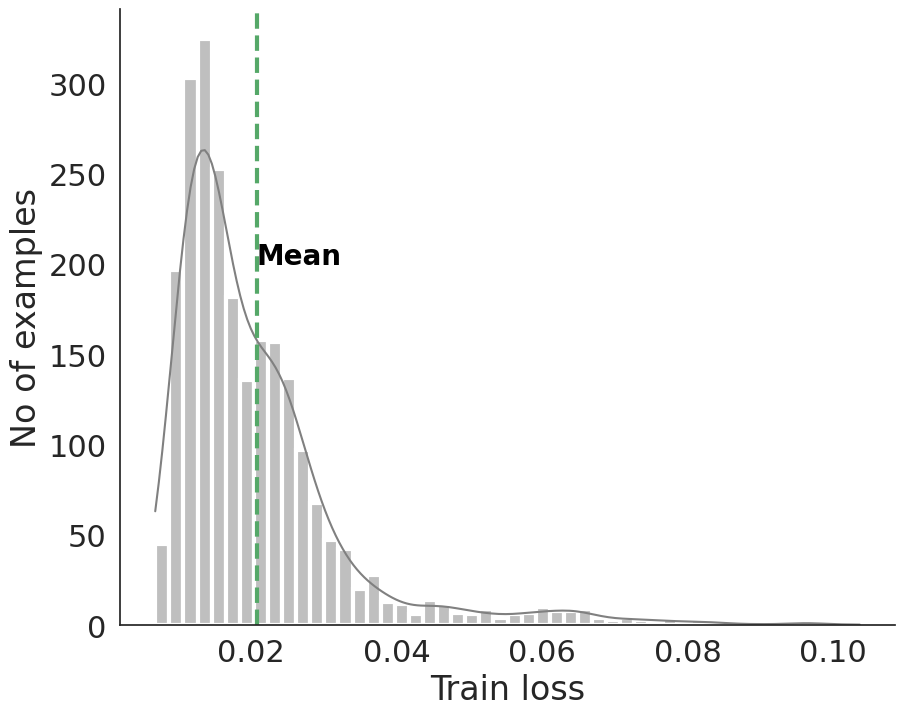

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, color='grey', linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left',  #텍스트 가로 정렬 왼쪽으로
         size='small', color='black', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

Let's choose a threshold with a standard deviation higher than the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033171885


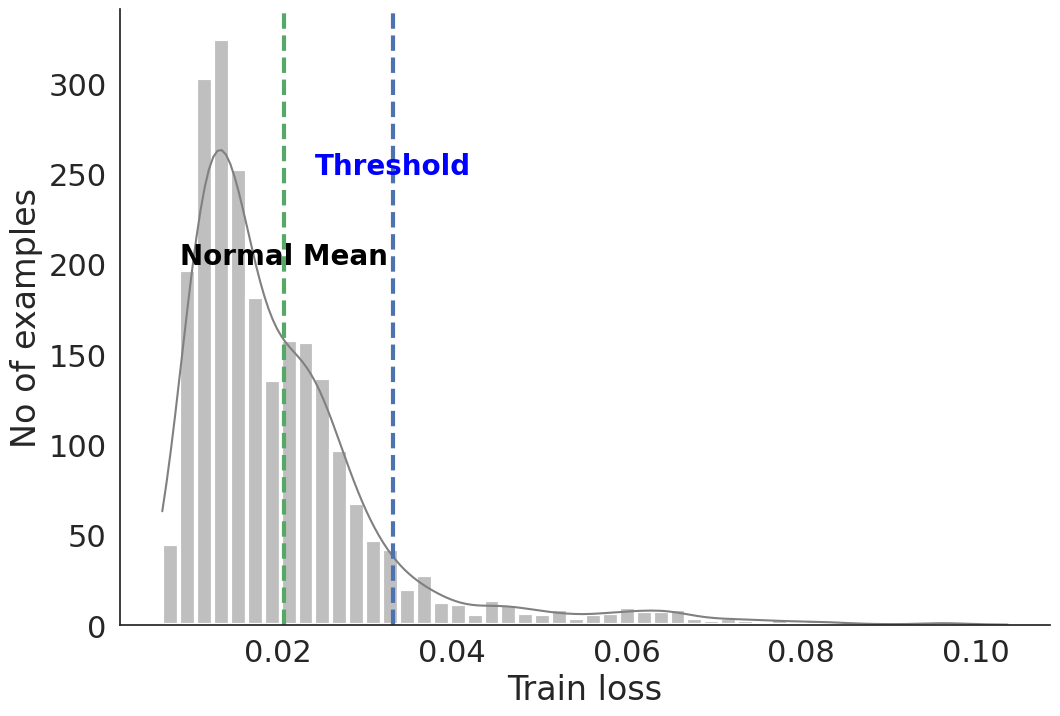

In [ ]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, color='grey', linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center',  #가로 정렬 중앙으로
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

**Examining reconstruction errors for unusual examples in the test set reveals that most of them have reconstruction errors greater than the threshold(blue-dotted line=0.033).**

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

14/14 [==============================] - 0s 3ms/step


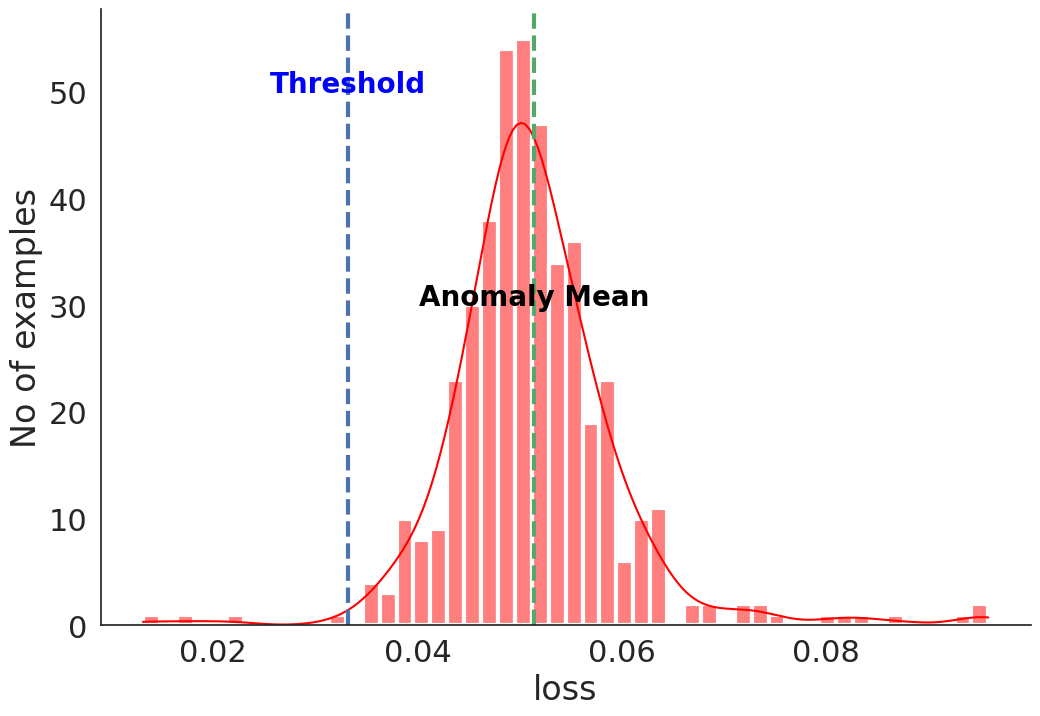

In [ ]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss, bins=50, kde=True, color='red', linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

If the reconstruction error is greater than the threshold(blue-dotted line), classify the ECG as abnormal.

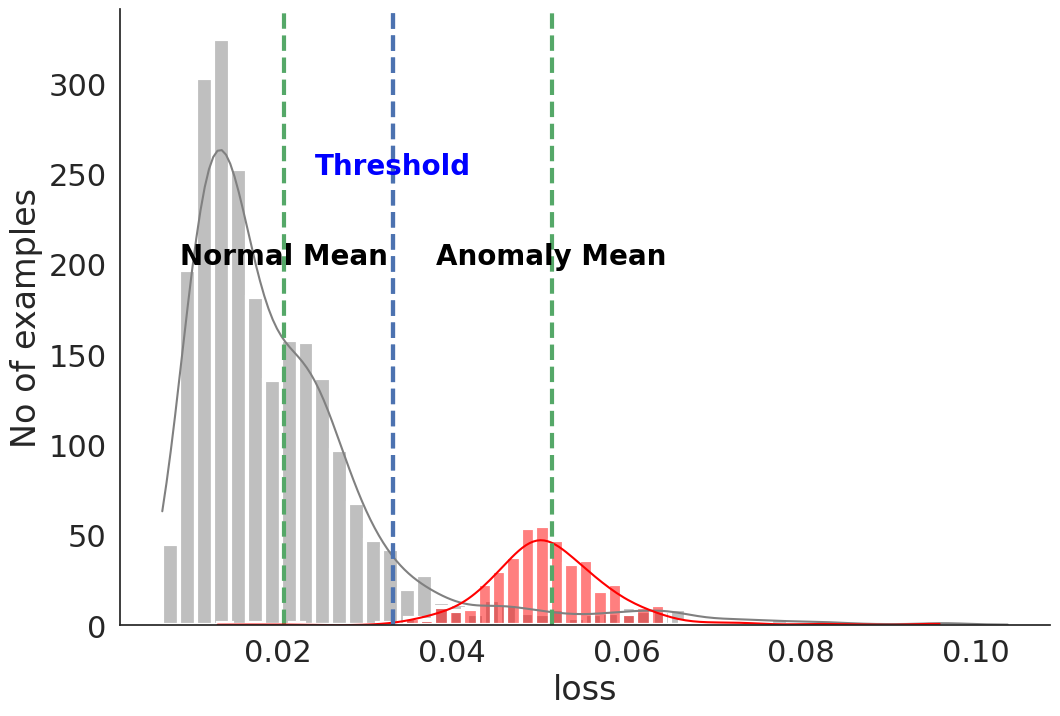

In [ ]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, color='grey', linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
sns.histplot(test_loss, bins=50, kde=True, color='red', linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

Looking at the picture above, it seems that the threshold was set by considering the Normal and Anomaly distributions well. In particular, it seems that recall is more important than precision for abnomaly detection. In actual application, it may be necessary to consider fine-tuning the threshold.

# Predicting

In [ ]:
def predict(model, data, threshold):
    #주어진 모델을 사용하여 입력 데이터의 재구성을 생성
    reconstructions = model(data)
    #재구성 손실 계산
    loss = tf.keras.losses.mae(reconstructions, data)
    #재구성 손실이 임계값보다 작으면 True 반환
    return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.946
Precision = 0.9922178988326849
Recall = 0.9107142857142857


confusion matrix
[[436   4]
 [ 50 510]]
accuracy: 0.9460, precision: 0.9922, recall: 0.9107,    F1: 0.9497, AUC:0.9508


<Axes: >

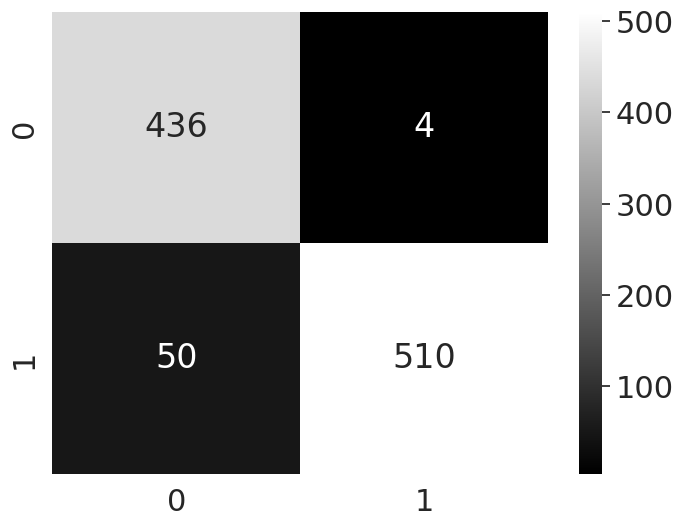

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, preds)
get_clf_eval(test_labels, preds, preds)

plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(cm, cmap = 'gist_yarg_r', annot = True, fmt='d')